In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [25]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']

In [18]:
data.columns

Index(['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc',
       'cadiovascular_current', 'bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'friedewald_ldl_c_c_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'site', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc'],
      dtype='object')

In [26]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [27]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [28]:
dff.cimt_mean_max.value_counts()

-999.000    197
 0.640       72
 0.720       46
 0.620       45
 0.700       42
           ... 
 1.050        1
 0.910        1
 0.745        1
 1.030        1
 1.190        1
Name: cimt_mean_max, Length: 138, dtype: int64

In [8]:
dff

,htn_jnc7_qc,diabetes_status_c_qc,ckd_c_qc,cadiovascular_current,bmi_c_qc,age,cimt_mean_max,cholesterol_1_qc,friedewald_ldl_c_c_qc,hdl_qc,...,site,sex,hiv_final_status_c,highest_level_of_education_qc,partnership_status_c_qc,ses_site_quintile_c_qc,occupation_qc,mvpa_cat_c,alcohol_use_status_c_qc,smoking_status_c_qc
361,0,0,0,0.0,23.83,57,0.640,5.71,4.070909,1.38,...,1,0,0,0,2,2,2,1.0,0,0
366,1,0,0,0.0,27.02,56,0.870,4.45,2.694545,1.46,...,1,0,0,1,2,4,4,1.0,0,0
367,0,0,0,0.0,20.34,56,0.760,3.72,2.255455,1.01,...,1,1,1,1,2,2,4,1.0,3,2
371,0,0,1,0.0,37.42,45,0.640,4.05,2.310909,1.13,...,1,0,0,3,1,5,2,1.0,0,0
375,0,0,0,0.0,16.33,43,0.635,2.03,0.787273,0.92,...,1,1,1,2,0,2,4,1.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,1,0,0,0.0,15.82,58,0.760,4.84,2.485455,2.00,...,1,1,1,0,1,2,4,1.0,1,1
4477,1,1,0,0.0,32.46,48,0.635,3.37,2.040000,1.08,...,1,1,0,2,1,4,3,0.0,0,0
4478,0,0,0,0.0,36.09,51,0.780,5.02,2.829091,1.70,...,1,1,0,0,1,1,4,0.0,1,0
4484,0,0,0,0.0,26.17,50,0.640,3.73,2.250909,1.17,...,1,1,0,1,1,5,4,1.0,3,0


In [29]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)]
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


<Axes: ylabel='Density'>

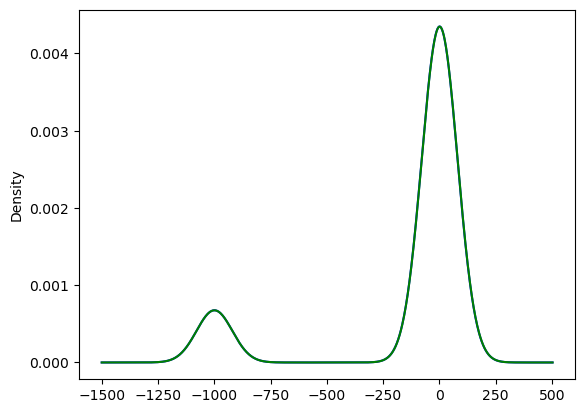

In [30]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff)
train_t = imputer.transform(dff)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff.columns)
treated = treated.apply(np.ceil)

fig = plt.figure()
ax = fig.add_subplot(111)
dff['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [7]:
dff['cimt_mean_max'].isnull().sum()

0

In [31]:
target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
dff[target_col] = (dff[target_cols] == 1).sum(axis = 1) == 2

# defining the expectations as mean of the target
dff['expectation'] = dff[target_col].mean()
dff['expectation'].head()

361    0.050512
366    0.050512
367    0.050512
371    0.050512
375    0.050512
Name: expectation, dtype: float64

In [57]:
dff['diab_hyp']

361     False
366     False
367     False
371     False
375     False
        ...  
4475    False
4477     True
4478    False
4484    False
4485    False
Name: diab_hyp, Length: 1465, dtype: bool

In [32]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in dff.columns \
                if col not in \
                [target_col, 'site', 'study_id', 'expectation', \
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [41]:
search_space

['bmi_c_qc',
 'age',
 'cimt_mean_max',
 'cholesterol_1_qc',
 'friedewald_ldl_c_c_qc',
 'hdl_qc',
 'triglycerides_qc',
 'waist_hip_r_c_qc',
 'waist_circumference_qc',
 'visceral_fat_qc',
 'subcutaneous_fat_qc',
 'sex',
 'hiv_final_status_c',
 'highest_level_of_education_qc',
 'partnership_status_c_qc',
 'ses_site_quintile_c_qc',
 'occupation_qc',
 'mvpa_cat_c',
 'alcohol_use_status_c_qc',
 'smoking_status_c_qc']

In [33]:
len(search_space)

20

In [34]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [35]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [36]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'

    return desc[:-5].replace('_',' ').replace('{', '(').replace('}', ')')

In [40]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'waist_hip_r_c_qc': ['1.0 - 1.16'], 'triglycerides_qc': ['1.14 - 1.49', '1.49 - 5.34'], 'hiv_final_status_c': [0], 'mvpa_cat_c': [1.0], 'hdl_qc': ['1.14 - 1.22', '1.22 - 1.31'], 'cimt_mean_max': ['0.68 - 0.71', '0.71 - 0.74', '0.74 - 0.78', '0.78 - 0.84', '0.84 - 1.7', -999.0]}, Score = 13.898686417884562
Penalty = 2: Subset = {'cimt_mean_max': ['0.78 - 0.84', '0.84 - 1.7', -999.0], 'waist_hip_r_c_qc': ['1.0 - 1.16']}, Score = 10.68150231946813
Penalty = 3: Subset = {'age': ['47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0', '57.0 - 58.0', '58.0 - 60.0'], 'waist_circumference_qc': ['990.0 - 1040.0', '1040.0 - 1110.0', '1110.0 - 1470.0'], 'hiv_final_status_c': [0]}, Score = 8.362179059604323
Penalty = 4: Subset = {'waist_hip_r_c_qc': ['1.0 - 1.16']}, Score = 6.858589707651763
Penalty = 5: Subset = {'waist_hip_r_c_qc': ['1.0 - 1.16']}, Score = 5.858589707651763
Penalty = 6: Subset = {'waist_hip_r_c_qc': ['1.0 - 1.16']}, Score = 4.85858970765

In [37]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)

penalty = 2
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 228 ms, sys: 75.8 ms, total: 304 ms
Wall time: 4.91 s


({'cimt_mean_max': ['0.78 - 0.84', '0.84 - 1.7', -999.0],
  'waist_hip_r_c_qc': ['1.0 - 1.16']},
 10.68150231946813)

In [38]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

cimt mean max = (0.78 - 1.7 OR -999.0) AND
waist hip r c qc = (1.0 - 1.16)


In [41]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 130 
Recall that our population average is 0.05051194539249147      
In this subgroup, we observe a mean outcome of 0.162
With 21 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 3.621


In [43]:
group_obs

0.16153846153846155

In [44]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 12.56486285033507
Penalty = 2: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 10.56486285033507
Penalty = 3: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 9.461265634299018
Penalty = 4: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 8.461265634299018
Penalty = 5: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 7.461265634299018
Penalty = 6: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 6.461265634299018
Penalty = 7: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '74

In [45]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)

penalty = 2
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 218 ms, sys: 62.5 ms, total: 281 ms
Wall time: 4.48 s


({'cimt_mean_max': ['0.78 - 0.84', '0.84 - 1.7', -999.0],
  'waist_hip_r_c_qc': ['1.0 - 1.16']},
 10.68150231946813)

In [46]:
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

cimt mean max = (0.78 - 1.7 OR -999.0) AND
waist hip r c qc = (1.0 - 1.16)


In [47]:
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average\
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 48 
Recall that our population average is 0.050511945392491465      
In this subgroup, we observe a mean outcome of 0.312
With 15 individuals in the group above average      
This is a multiplicative factor in the odds (i.e q) of 8.544
